In [6]:
import librosa
import numpy as np

def segment_audio(y, sr, segment_length_sec=5):
    segment_length_samples = int(segment_length_sec * sr)
    
    # Calculate the number of segments
    num_segments = int(np.ceil(len(y) / segment_length_samples))
    
    # Create segments
    segments = []
    for i in range(num_segments):
        start_sample = i * segment_length_samples
        end_sample = start_sample + segment_length_samples
        segments.append(y[start_sample:end_sample])
    
    return segments[1:len(segments)-2]


In [24]:
import librosa
import numpy as np
import os
import pickle

g=os.listdir("wav_files")
mfccs_size=0

spectrals=[]
for vidfile in g:

    dr=librosa.get_duration(path=f"wav_files/{vidfile}")
    y,sr = librosa.load(f"wav_files/{vidfile}",sr=22050)
    segments=segment_audio(y,sr)
    
    segment_mfccs_mean=[]
    segment_mfccs_max=[]
    segment_chromagram=[]
    segment_spectral_contrast=np.array([])
    segment_zero_crossings=[]
    for cnt,y in enumerate(segments):
        print(f"Treating segment {cnt}")




        mfccs = librosa.feature.mfcc(y=y, sr=sr)



        chromagram = librosa.feature.chroma_stft(y=y, sr=sr).mean(axis=1)
        segment_chromagram.append(chromagram)



        mfccs_mean = np.mean(mfccs, axis=0)[::2]
        mfccs_max = np.max(mfccs, axis=0)[::2]
        segment_mfccs_mean.append(mfccs_mean)
        segment_mfccs_max.append(mfccs_max)



        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=5).mean(axis=1)
        segment_spectral_contrast.append(spectral_contrast)
        print(segment_spectral_contrast.shape)




        zero_crossings = librosa.zero_crossings(y, pad=False)
        segment_zero_crossings.append(zero_crossings)


    mfccs_mean=np.mean(segment_mfccs_mean)
    mfccs_max=np.mean(segment_mfccs_max)
    chromagram=np.mean(segment_chromagram)
    zero_crossings=np.mean(segment_zero_crossings)
    spectral_contrast=np.mean(segment_spectral_contrast)


    chromagram_size=len(chromagram)
    spectral_contrast_size=len(spectral_contrast)
    mfccs_size=len(mfccs_mean)


        
    song_characteristics=np.concatenate((mfccs_mean,mfccs_max))


    song_characteristics=np.concatenate((song_characteristics,[sum(zero_crossings)]))


    song_characteristics=np.concatenate((song_characteristics,chromagram))


    song_characteristics=np.concatenate((song_characteristics,spectral_contrast))

    spectrals.append(song_characteristics)
    #https://towardsdatascience.com/extract-features-of-music-75a3f9bc265dnp.array(sum(zero_crossings))
spectrals=np.array(spectrals)
print(spectrals.shape)


Treating segment 0
Treating segment 1
Treating segment 2
Treating segment 3
Treating segment 4
Treating segment 5
Treating segment 6
Treating segment 7
Treating segment 8
Treating segment 9
Treating segment 10
Treating segment 11
Treating segment 12
Treating segment 13
Treating segment 14
Treating segment 15
Treating segment 16
Treating segment 17
Treating segment 18
Treating segment 19
Treating segment 20
Treating segment 21
Treating segment 22
Treating segment 23
Treating segment 24
Treating segment 25
Treating segment 26
Treating segment 27
Treating segment 28
Treating segment 29
Treating segment 30
Treating segment 31
Treating segment 32
Treating segment 33
Treating segment 34
Treating segment 35
Treating segment 36
Treating segment 37
Treating segment 38
Treating segment 39
Treating segment 40
Treating segment 41
Treating segment 42
43


TypeError: object of type 'numpy.float32' has no len()

In [182]:
import sklearn
#Mean, max, zero
spectrals_n=sklearn.preprocessing.normalize(spectrals,axis=0)

print(spectrals_n.shape)

print(mfccs_size)


(33, 7833)
3907


In [183]:
print(len(mfccs_mean))
print(len(mfccs_max))
print(sum(zero_crossings))
print(len(chromagram))
print(len(spectral_contrast))


3907
3907
310620
12
6


### Spectral array:
- First n columns [0,mfccs_size] are the MCCF mean
- Second n columns, [mfccs_size,mfccs_size*2[ are the MCCF max.
- Next column, mfcc_size*2, is the  zero crossings
- Next, [mfcc_size*2+1,mfccs_ize*2+1+chromagram_size] are the chromagram
- then, [mfccs_size*2+1+chromagram_size,mfccssize*2+1+chromagram_size+spectral_size] is the spectral contrast 

In [184]:
from sklearn.decomposition import PCA



#For means
spectral_n_means=spectrals_n[:,:mfccs_size]
print(spectral_n_means.shape)
pca = PCA(n_components=9)
 
pca_means=pca.fit_transform(spectral_n_means)
#print(pca.components_)
#print(pca.explained_variance_)

print(pca_means.shape)

#retain 5

(33, 3907)
(33, 9)


In [185]:
#For maxes
spectral_n_maxes=spectrals_n[:,mfccs_size:mfccs_size*2]
print(spectral_n_maxes.shape)
pca = PCA(n_components=9)
 
pca_maxes=pca.fit_transform(spectral_n_maxes)
#print(pca.components_)
print(pca.explained_variance_)
print(pca_maxes.shape)

#retain 5

(33, 3907)
[5.88416594 1.23021515 0.98290727 0.74439979 0.6848537  0.63013296
 0.56674801 0.55536955 0.53933448]
(33, 9)


In [187]:

#Max and mean
reduced_spectral=np.concatenate((pca_maxes,pca_means),axis=1)
print(reduced_spectral.shape)

#Spectrals t
reduced_spectral=np.concatenate((reduced_spectral,spectrals_n[:,2*mfccs_size:]),axis=1)



print(reduced_spectral.shape)

(33, 18)
(33, 37)


In [190]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
K = range(1, 12)

for k in K:
	# Building and fitting the model
	kmeanModel = KMeans(n_clusters=k,n_init=10).fit(reduced_spectral)
	kmeanModel.fit(reduced_spectral)

	distortions.append(sum(np.min(cdist(reduced_spectral, kmeanModel.cluster_centers_,
										'euclidean'), axis=1)) / reduced_spectral.shape[0])
	inertias.append(kmeanModel.inertia_)

	mapping1[k] = sum(np.min(cdist(reduced_spectral, kmeanModel.cluster_centers_,
								'euclidean'), axis=1)) / reduced_spectral.shape[0]
	mapping2[k] = kmeanModel.inertia_


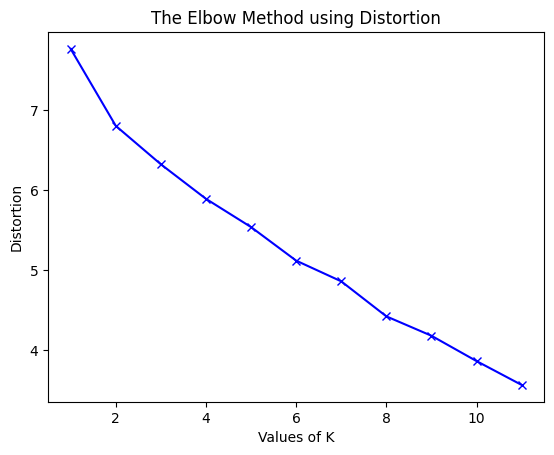

In [191]:
import matplotlib.pyplot as plt
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [194]:

kmeanModel = KMeans(n_clusters=8).fit(reduced_spectral)
kmeanModel.fit(reduced_spectral)
print(kmeanModel.labels_)

/home/hakosaj/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 5 0 1 0 4 1 4 1 0 4 1 0 2 0 4 1 6 0 1 1 0 3 1 2 1 2 2 0 2 2 0 7]


/home/hakosaj/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [195]:
for c, value in enumerate(g):
    print(f"{value.replace('.wav',''):50}   |  {kmeanModel.labels_[c]} ")

letsgetitstarted                                     |  1 
youdontknowme                                        |  5 
neverbethesame                                       |  0 
righthereinmyarms                                    |  1 
legendary                                            |  0 
heathens                                             |  4 
soundgardenblackholesunwithlyrics                    |  1 
virtualinsanity                                      |  4 
justintimberlake-mylove                              |  1 
latch                                                |  0 
sweetdreams                                          |  4 
kohtalo                                              |  1 
doiwannaknow?                                        |  0 
bettergiveuup                                        |  2 
3doorsdown-kryptonite                                |  0 
disturbia                                            |  4 
redhotchilipeppers-ifyouwantmetostay                 |  